In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

In [2]:
# Suppress warnings for n_init
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.cluster._kmeans')

In [3]:
# --- Problem 1: Load and Preprocess ---
df = pd.read_csv('mallcustomers.csv')

In [4]:
# Clean the 'Income' column by removing "," and " USD" 
df['Income'] = df['Income'].str.replace(',', '')
df['Income'] = df['Income'].str.replace(' USD', '')

In [5]:
# Convert 'Income' to numeric 
df['Income'] = pd.to_numeric(df['Income'])
print("Problem 1: 'Income' column cleaned and converted to numeric.")

Problem 1: 'Income' column cleaned and converted to numeric.


In [6]:
# --- Problem 2: Exclude CustomerID ---
# Eliminate 'CustomerID'. We keep Age and Gender for Problem 5.
df = df.drop(columns=['CustomerID'])
print("Problem 2: 'CustomerID' column removed.")

Problem 2: 'CustomerID' column removed.


In [7]:
# --- Problem 3: Statistics and Normalization ---
print("\n--- Problem 3 Output: Summary Statistics ---")
# Run summary statistics for Income and SpendingScore 
stats = df[['Income', 'SpendingScore']].describe()
print(stats)


--- Problem 3 Output: Summary Statistics ---
              Income  SpendingScore
count     200.000000     200.000000
mean    60560.000000      50.200000
std     26264.721165      25.823522
min     15000.000000       1.000000
25%     41500.000000      34.750000
50%     61500.000000      50.000000
75%     78000.000000      73.000000
max    137000.000000      99.000000


In [8]:
# Normalize this data using the z-score normalization approach 
scaler = StandardScaler()

# We only scale the data used for clustering
scaled_data = scaler.fit_transform(df[['Income', 'SpendingScore']])
print("Problem 3: Data normalized using z-score.")

Problem 3: Data normalized using z-score.


In [9]:
# --- Problem 4: K-Means Clustering ---

# Use the Elbow Method to determine an optimal number of clusters 
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_elbow.fit(scaled_data)
    inertia.append(kmeans_elbow.inertia_)


Problem 4: 'elbow_plot.png' saved.


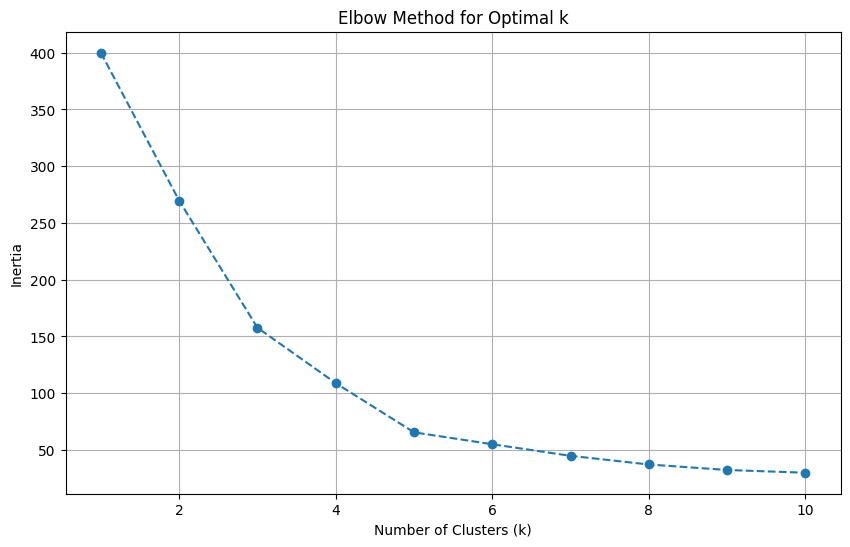

In [10]:
# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_plot.png')
print("\nProblem 4: 'elbow_plot.png' saved.")

In [11]:
# Based on the elbow plot, k=5 is the optimal number.
optimal_k = 5

In [12]:
# Create the final set of clusters and visualize the results 
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(scaled_data)

In [13]:
# Add cluster labels back to the original DataFrame
df['Cluster'] = clusters

Problem 4: 'cluster_visualization.png' saved.


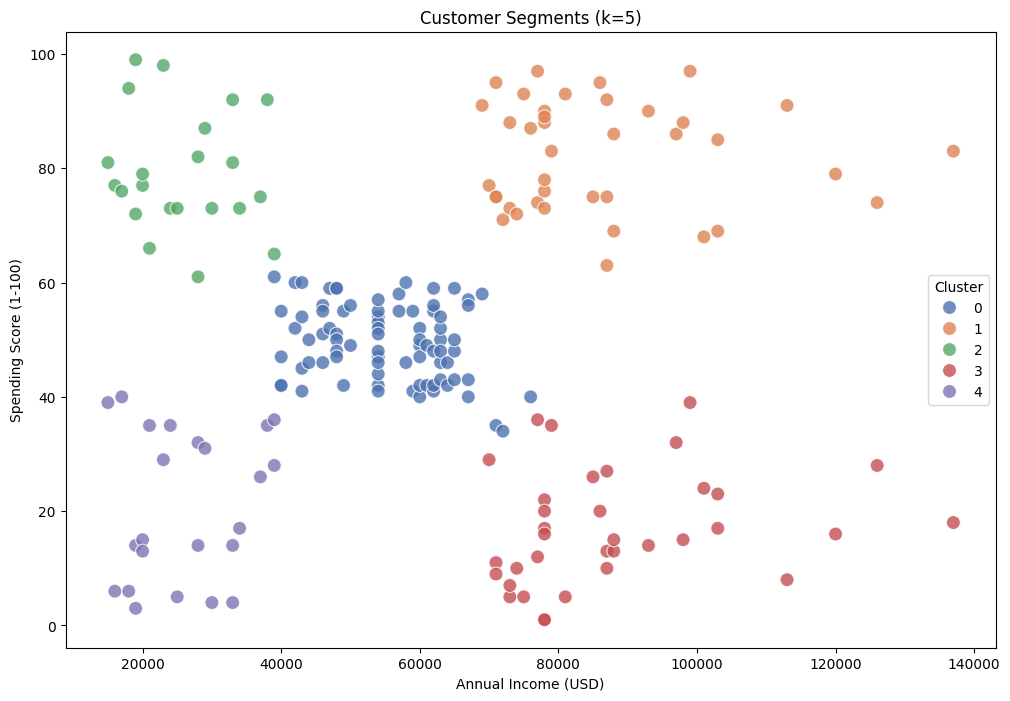

In [14]:
# Visualize the results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='Income',
    y='SpendingScore',
    hue='Cluster',
    palette='deep',
    s=100,
    alpha=0.8
)
plt.title('Customer Segments (k=5)')
plt.xlabel('Annual Income (USD)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.savefig('cluster_visualization.png')
print("Problem 4: 'cluster_visualization.png' saved.")

In [15]:
# --- Problem 5: Evaluating the Clusters ---
# To help "give names to each cluster" , let's look at the centers
# We must use .inverse_transform to see the centers in their original scale
cluster_centers = scaler.inverse_transform(kmeans_final.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=['Income_Center', 'SpendingScore_Center'])
print("\n--- Problem 5 Output: Cluster Centers (Original Scale) ---")
print(centers_df)

# Use Gender and Age to determine gender distribution and mean age  
df_dummies = pd.get_dummies(df, columns=['Gender'])

# Determine gender distribution and mean age for each cluster
cluster_analysis = df_dummies.groupby('Cluster').agg(
    Mean_Age=('Age', 'mean'),
    Percent_Female=('Gender_Female', 'mean'),
    Percent_Male=('Gender_Male', 'mean'),
    Count=('Cluster', 'size')
)

# Format for readability
cluster_analysis['Mean_Age'] = cluster_analysis['Mean_Age'].round(2)
cluster_analysis['Percent_Female'] = (cluster_analysis['Percent_Female'] * 100).round(2)
cluster_analysis['Percent_Male'] = (cluster_analysis['Percent_Male'] * 100).round(2)

print("\n--- Problem 5 Output: Cluster Demographic Analysis ---")
print(cluster_analysis)


--- Problem 5 Output: Cluster Centers (Original Scale) ---
   Income_Center  SpendingScore_Center
0   55296.296296             49.518519
1   86538.461538             82.128205
2   25727.272727             79.363636
3   88200.000000             17.114286
4   26304.347826             20.913043

--- Problem 5 Output: Cluster Demographic Analysis ---
         Mean_Age  Percent_Female  Percent_Male  Count
Cluster                                               
0           42.72           59.26         40.74     81
1           32.69           53.85         46.15     39
2           25.27           59.09         40.91     22
3           41.11           45.71         54.29     35
4           45.22           60.87         39.13     23
